In [2]:
import os
import sys
import io

import numpy as np

import pandas as pd

from PIL import Image

REPO_DIR = os.path.join(os.environ['HOME'], 'github_repos')
sys.path.append(os.path.join(REPO_DIR, 'partial-data/'))
from partial_data.visualization import draw_bounding_boxes_on_image
from partial_data.tfrecord import (create_label_map_pbtxt, encode_object_detection_tf_example, 
                                   decode_object_detection_tf_example, write_examples_as_tfrecord, 
                                   read_examples_from_tfrecord)

## Load annotations 

In [3]:
input_dir = './annotations'
partial_prefix = 'annotations_partial_'
complete_prefix = 'annotations_complete_'

df_partial_train = pd.read_csv(os.path.join(input_dir, partial_prefix+'train.csv'))
df_partial_val = pd.read_csv(os.path.join(input_dir, partial_prefix+'val.csv'))
df_partial_test = pd.read_csv(os.path.join(input_dir, partial_prefix+'test.csv'))
df_complete_train = pd.read_csv(os.path.join(input_dir, complete_prefix+'train.csv'))
df_complete_val = pd.read_csv(os.path.join(input_dir, complete_prefix+'val.csv'))
df_complete_test = pd.read_csv(os.path.join(input_dir, complete_prefix+'test.csv'))

## Visualize bounding boxes 

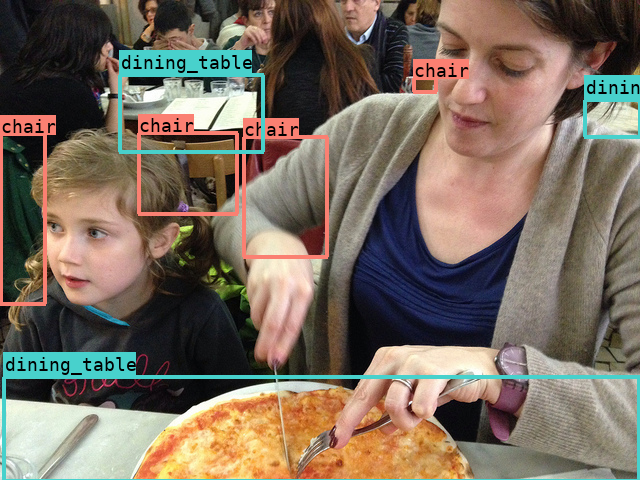

In [4]:
ind = 0

image_grps = df_complete_val.groupby('image_filepath')
image_filepaths = list(image_grps.groups.keys())
image_filepath = image_filepaths[ind]
df_image_grp = image_grps.get_group(image_filepath)
bboxes = df_image_grp[['hmin', 'wmin', 'hmax', 'wmax']].values
labels = [(nm,) for nm in df_image_grp['category_name']]
img = Image.open(image_filepath)
font_filepath = '/home/david/github_repos/fonts/DejaVuSansMono/DejaVu Sans Mono for Powerline.ttf'
draw_bounding_boxes_on_image(img, bboxes, 
                             font_size=18, font_filepath=font_filepath, 
                             display_str_list_list=labels)
img

## Create .pbtxt file

In [5]:
category_cols = ['category_name', 'category_id']
dataset_dfs = [df_partial_train, df_partial_val, df_partial_test, 
               df_complete_train, df_complete_val, df_complete_test]

df_category = pd.concat([df[category_cols].drop_duplicates() for df in dataset_dfs], axis=0).drop_duplicates()
label_map = [{'name': nm, 'display_name': nm, 'id': ind,} for _, (nm, ind) in df_category.iterrows()]
create_label_map_pbtxt(label_map, 'tfrecord/label_map.pbtxt')

## Serialize TFRecord datasets

In [6]:
agg_cols = ['wmin', 'wmax', 'hmin', 'hmax', 'category_name', 'category_id']
grp_cols = ['image_filepath', 'image_id']
tfrecord_output_filepaths = [f'tfrecord/partial_{split}.record' for split in ['train', 'val', 'test']] + \
                            [f'tfrecord/complete_{split}.record' for split in ['train', 'val', 'test']]

for output_filepath, df_dataset in zip(tfrecord_output_filepaths, dataset_dfs):
    print(output_filepath)
    df_example = df_dataset.groupby(grp_cols).agg({col: list for col in agg_cols}).reset_index()
    examples = [row for _, row in df_example.iterrows()]
    write_examples_as_tfrecord(
        examples,
        output_filepath,
        encode_object_detection_tf_example,
        num_shards=3
    )

tfrecord/partial_train.record


100%|██████████| 15595/15595 [03:13<00:00, 80.57it/s] 


tfrecord/partial_val.record


100%|██████████| 2275/2275 [00:15<00:00, 151.10it/s]


tfrecord/partial_test.record


100%|██████████| 4482/4482 [00:45<00:00, 98.15it/s] 


tfrecord/complete_train.record


100%|██████████| 15595/15595 [01:31<00:00, 169.91it/s]


tfrecord/complete_val.record


100%|██████████| 2275/2275 [00:15<00:00, 149.12it/s]


tfrecord/complete_test.record


100%|██████████| 4482/4482 [00:35<00:00, 125.03it/s]
